In [1]:
import requests
import yfinance as yf
from functools import reduce

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor 
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.pipeline import make_pipeline
import pickle

import warnings
warnings.filterwarnings('ignore')

### 1. Data Collection & Preprocessing

#### Fear & Greed Index API

In [4]:
# https://alternative.me/crypto/fear-and-greed-index/
url = 'https://api.alternative.me/fng/'
params = {
    'limit': 0,  # all available data
    'format': 'csv',
    'date_format': 'cn' # YYYY-MM-DD
}
response = requests.get(url,params)
response.status_code

200

In [5]:
lines = response.text.splitlines()
lines.reverse()
lines[:7], '#######', lines[-7:]

(['}',
  '\t}',
  '\t\t"error": null',
  '\t"metadata": {',
  '\t],',
  '2018-02-01,30,Fear',
  '2018-02-02,15,Extreme Fear'],
 '#######',
 ['2024-09-20,54,Neutral',
  '2024-09-21,54,Neutral',
  '2024-09-22,52,Neutral',
  'fng_value,fng_classification,date',
  '\t"data": [',
  '\t"name": "Fear and Greed Index",',
  '{'])

In [6]:
date, fng_value, fng_class = [], [], []

for line in lines[5:-7]: # tweak to change timeframe
    values = line.split(',')
    date.append(values[0])
    fng_value.append(values[1])
    fng_class.append(values[2])
    
fng_df = pd.DataFrame({
    'date': date,
    'fng_value': fng_value,
    'fng_class': fng_class,
})

# fng_df.to_csv('datasets/fear_and_greed_index.csv',index=False) # save locally
fng_df = pd.read_csv('datasets/fear_and_greed_index.csv') # read locally (prevents dtype issues on merge)
fng_df

date  fng_value     fng_class
0     2018-02-01         30          Fear
1     2018-02-02         15  Extreme Fear
2     2018-02-03         40          Fear
3     2018-02-04         24  Extreme Fear
4     2018-02-05         11  Extreme Fear
...          ...        ...           ...
2415  2024-09-15         51       Neutral
2416  2024-09-16         39          Fear
2417  2024-09-17         33          Fear
2418  2024-09-18         45          Fear
2419  2024-09-19         49       Neutral

[2420 rows x 3 columns]

#### Yahoo Finance API, Intra-Pair Feature Engineering

In [8]:
currency_pairs = [
    'BTC-USD', # https://finance.yahoo.com/quote/BTC-USD/history/
    # 'BTC-EUR',
    # 'ETH-USD',
    # 'ETH-EUR'
]
dfs = []

for pair in currency_pairs:
    df = yf.download(pair)
    # df.to_csv(f"datasets/{pair}.csv") # save locally
    df = pd.read_csv(f"datasets/{pair}.csv") # read locally (prevents dtype issues on merge)
    df.drop(columns='Adj Close',inplace=True) # Close/Adj Close identical

    # engineer intra-pair features
    df['Close_t+1'] = df['Close'].shift(-1)
    df['close_change'] = df['Close'].diff()
    df['close_t+1_change'] = df['Close_t+1'].diff()
    # simple moving averages
    df['sma_3d'] = df['Close'].rolling(window=3).mean()
    df['sma_7d'] = df['Close'].rolling(window=7).mean()
    df['sma_14d'] = df['Close'].rolling(window=14).mean()
    # exponential moving averages
    df['ema_5d'] = df['Close'].ewm(span=5,adjust=False).mean()
    df['ema_10d'] = df['Close'].ewm(span=10,adjust=False).mean()
    df['ema_21d'] = df['Close'].ewm(span=21,adjust=False).mean()
    # bollinger bands (captures price volatility; sma_14d = middle band)
    df['std_14d'] = df['Close'].rolling(window=14).std()
    df['upper_band'] = df['sma_14d'] + (2 * df['std_14d'])
    df['lower_band'] = df['sma_14d'] - (2 * df['std_14d'])

    # relative strength index (measures overbought/oversold conditions)
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=7).mean()
    avg_loss = loss.rolling(window=7).mean()
    
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # 1/0 = greater/less than previous day's value
    df['close_dir'] = (df['Close'].diff() > 0).astype(int)
    df['high_dir'] = (df['High'].diff() > 0).astype(int)
    df['low_dir'] = (df['Low'].diff() > 0).astype(int)
    df['volume_dir'] = (df['Volume'].diff() > 0).astype(int)
    
    if pair == 'BTC-USD':
        df['target'] = (df['Close_t+1'] > df['Close']).astype(int) # if tomorrow's close > today's

    df.columns = [col.lower() for col in df.columns]
    # # Date not suffixed as joining on it
    # df.columns = [col.lower() if i == 0 or col == 'target' else f"{col.lower()}_{value.lower().replace('-','_')}" for i, col in enumerate(df.columns)]
    dfs.append(df)

print(f"Dataframes: {len(dfs)}")
dfs[0]

[*********************100%***********************]  1 of 1 completed

Dataframes: 1


date          open          high           low         close  \
0     2014-09-17    465.864014    468.174011    452.421997    457.334015   
1     2014-09-18    456.859985    456.859985    413.104004    424.440002   
2     2014-09-19    424.102997    427.834991    384.532013    394.795990   
3     2014-09-20    394.673004    423.295990    389.882996    408.903992   
4     2014-09-21    408.084991    412.425995    393.181000    398.821014   
...          ...           ...           ...           ...           ...   
3652  2024-09-16  59185.226562  59205.511719  57501.339844  58192.507812   
3653  2024-09-17  58192.507812  61316.089844  57628.070312  60308.539062   
3654  2024-09-18  60309.000000  61664.066406  59218.253906  61649.679688   
3655  2024-09-19  61651.156250  63872.441406  61609.867188  62940.457031   
3656  2024-09-22  63376.269531  63451.492188  62853.457031  62988.171875   

           volume     close_t+1  close_change  close_t+1_change        sma_3d  \
0        21056800    424.440002           NaN               NaN           NaN   
1        34483200    394.795990    -32.894012        -29.644012           NaN   
2        37919700    408.903992    -29.644012         14.108002    425.523336   
3        36863600    398.821014     14.108002        -10.082977    409.379995   
4        26580100    402.152008    -10.082977          3.330994    400.840332   
...           ...           ...           ...               ...           ...   
3652  32032822113  60308.539062   -990.328125       2116.031250  59126.821615   
3653  38075570118  61649.679688   2116.031250       1341.140625  59227.960938   
3654  40990702891  62940.457031   1341.140625       1290.777344  60050.242188   
3655  42710252573  62988.171875   1290.777344         47.714844  61632.891927   
3656  14216100864           NaN     47.714844               NaN  62526.102865   

      ...       ema_21d      std_14d    upper_band    lower_band        rsi  \
0     ...    457.334015          NaN           NaN           NaN        NaN   
1     ...    454.343650          NaN           NaN           NaN        NaN   
2     ...    448.930226          NaN           NaN           NaN        NaN   
3     ...    445.291478          NaN           NaN           NaN        NaN   
4     ...    441.066890          NaN           NaN           NaN        NaN   
...   ...           ...          ...           ...           ...        ...   
3652  ...  58404.891716  2005.094486  61337.564251  53317.186307  58.965437   
3653  ...  58577.950565  2158.176043  61849.264195  53216.560024  66.564929   
3654  ...  58857.198667  2423.275826  62642.188091  52949.084788  73.755865   
3655  ...  59228.403973  2729.489907  63738.899736  52820.940107  75.145907   
3656  ...  59570.201055  2695.061422  64315.715478  53535.469790  66.843582   

      close_dir  high_dir  low_dir  volume_dir  target  
0             0         0        0           0       0  
1             0         0        0           1       0  
2             0         0        0           1       1  
3             1         0        1           0       0  
4             0         0        1           0       1  
...         ...       ...      ...         ...     ...  
3652          0         0        0           1       1  
3653          1         1        1           1       1  
3654          1         1        1           1       1  
3655          1         1        1           1       1  
3656          1         0        1           0       0  

[3657 rows x 24 columns]

#### Merging, Miscellaneous Feature Engineering

In [10]:
# merge left on fng_df date (smallest timeframe of datasets used)
df = reduce(lambda left,right: pd.merge(left,right,how='left',on='date'), dfs, fng_df)
fng_df.shape, df.shape

((2420, 3), (2420, 26))

In [11]:
# if >1 pair, inter-pair feature engineering

# fng-based feature
df['fng_change'] = df['fng_value'].diff()

# time-based features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek

pd.set_option('display.max_columns',None)
df

date  fng_value     fng_class          open          high  \
0    2018-02-01         30          Fear  10237.299805  10288.799805   
1    2018-02-02         15  Extreme Fear   9142.280273   9142.280273   
2    2018-02-03         40          Fear   8852.120117   9430.750000   
3    2018-02-04         24  Extreme Fear   9175.700195   9334.870117   
4    2018-02-05         11  Extreme Fear   8270.540039   8364.839844   
...         ...        ...           ...           ...           ...   
2415 2024-09-15         51       Neutral  60000.726562  60381.917969   
2416 2024-09-16         39          Fear  59185.226562  59205.511719   
2417 2024-09-17         33          Fear  58192.507812  61316.089844   
2418 2024-09-18         45          Fear  60309.000000  61664.066406   
2419 2024-09-19         49       Neutral  61651.156250  63872.441406   

               low         close       volume     close_t+1  close_change  \
0      8812.280273   9170.540039   9959400448   8830.750000  -1050.559570   
1      7796.490234   8830.750000  12726899712   9174.910156   -339.790039   
2      8251.629883   9174.910156   7263790080   8277.009766    344.160156   
3      8031.220215   8277.009766   7073549824   6955.270020   -897.900391   
4      6756.680176   6955.270020   9285289984   7754.000000  -1321.739746   
...            ...           ...          ...           ...           ...   
2415  58696.308594  59182.835938  18120960867  58192.507812   -822.285156   
2416  57501.339844  58192.507812  32032822113  60308.539062   -990.328125   
2417  57628.070312  60308.539062  38075570118  61649.679688   2116.031250   
2418  59218.253906  61649.679688  40990702891  62940.457031   1341.140625   
2419  61609.867188  62940.457031  42710252573  62988.171875   1290.777344   

      close_t+1_change        sma_3d        sma_7d       sma_14d  \
0          -339.790039   9832.646484  10741.820033  11122.717285   
1           344.160156   9407.463216  10407.441406  10924.385114   
2          -897.900391   9058.733398  10083.757115  10658.364397   
3         -1321.739746   8760.889974   9582.429967  10421.000837   
4           798.729980   8135.729980   8962.268485  10136.991525   
...                ...           ...           ...           ...   
2415       -990.328125  59919.752604  58556.812500  57393.087612   
2416       2116.031250  59126.821615  58724.380022  57327.375279   
2417       1341.140625  59227.960938  59104.355469  57532.912109   
2418       1290.777344  60050.242188  59719.570871  57795.636440   
2419         47.714844  61632.891927  60407.205915  58279.919922   

            ema_5d       ema_10d       ema_21d      std_14d    upper_band  \
0     10210.587415  10769.754729  11685.743435   878.183843  12879.084972   
1      9750.641610  10417.208414  11426.198577  1055.869545  13036.124203   
2      9558.731125  10191.336004  11221.535993   986.961778  12632.287952   
3      9131.490672   9843.276688  10953.851791  1131.996887  12684.994612   
4      8406.083788   9318.184566  10590.344357  1448.605290  13034.202106   
...            ...           ...           ...          ...           ...   
2415  58991.675187  58365.989923  58426.130106  2050.195926  61493.479464   
2416  58725.286062  58334.447721  58404.891716  2005.094486  61337.564251   
2417  59253.037062  58693.373419  58577.950565  2158.176043  61849.264195   
2418  60051.917937  59230.883650  58857.198667  2423.275826  62642.188091   
2419  61014.764302  59905.351537  59228.403973  2729.489907  63738.899736   

        lower_band        rsi  close_dir  high_dir  low_dir  volume_dir  \
0      9366.349599  20.564994          0         0        0           1   
1      8812.646025  19.202364          0         0        0           1   
2      8684.440842  20.763314          1         1        1           0   
3      8157.007062  10.366799          0         0        0           0   
4      7239.780944   8.727050          0         0        0           1   
...            ...        ...

#### Null Values

In [13]:
nan = df.isna().sum()
nan[nan > 0]

fng_change    1
dtype: int64

In [14]:
df.fillna(0,inplace=True)
df.isna().sum().sum()

0

In [15]:
# df.to_csv('datasets/merged_dataset_with_features.csv',index=False)

### 2. Exploratory Data Analysis

In [17]:
df.describe().iloc[1:,1:] # omit count, date

fng_value          open          high           low         close  \
mean  45.945455  26014.147957  26591.269974  25398.108996  26034.245382   
min    5.000000   3236.274658   3275.377930   3191.303467   3236.761719   
25%   27.000000   8796.849854   8958.529785   8598.958740   8802.104492   
50%   44.000000  20877.533203  21443.148438  20504.435547  20903.642578   
75%   64.000000  40683.366211  41895.105469  39625.075195  40786.456055   
max   95.000000  73079.375000  73750.070312  71334.093750  73083.500000   
std   21.721439  19463.093960  19905.559650  18975.122764  19472.720140   

            volume     close_t+1  close_change  close_t+1_change  \
mean  2.607680e+10  26056.518846     21.717623         22.273464   
min   2.923670e+09   3236.761719  -7554.039062      -7554.039062   
25%   1.372318e+10   8802.104492   -247.013184       -246.693481   
50%   2.369278e+10  20951.392578      6.878662          7.240845   
75%   3.453431e+10  40804.760742    286.455688        286.455688   
max   3.509679e+11  73083.500000   7293.023438       7293.023438   
std   1.842841e+10  19484.148419   1074.129227       1073.902722   

            sma_3d        sma_7d       sma_14d        ema_5d       ema_10d  \
mean  26012.727915  25972.792871  25904.442269  25993.081812  25944.241885   
min    3244.028564   3351.422468   3462.801426   3304.842608   3425.148098   
25%    8783.975342   8760.115758   8796.531948   8771.539222   8793.239981   
50%   20953.373372  20819.537388  20567.131557  20822.525818  20883.081006   
75%   40566.240560  40639.678432  40510.830706  40706.160633  40824.560973   
max   72229.565104  70715.390625  69193.576730  71125.976519  69475.414282   
std   19448.321317  19407.857322  19340.371969  19416.730220  19355.241170   

           ema_21d      std_14d    upper_band    lower_band         rsi  \
mean  25839.477857  1199.518376  28303.479021  23505.405518   52.007009   
min    3531.128911    38.890180   3618.787646   2981.893079    0.000000   
25%    8829.935207   338.677966   9634.023976   7768.058346   33.893462   
50%   21216.344126   740.358286  22998.303983  18805.142550   51.574009   
75%   40824.391270  1806.723433  44651.055266  36129.829279   70.079935   
max   68665.693387  7358.200532  75027.935207  66924.307518  100.000000   
std   19216.909668  1171.133796  21106.285338  17708.673863   24.221438   

      close_dir  high_dir   low_dir  volume_dir    target  fng_change  \
mean   0.511983  0.480165  0.566116    0.484298  0.512810    0.007851   
min    0.000000  0.000000  0.000000    0.000000  0.000000  -45.000000   
25%    0.000000  0.000000  0.000000    0.000000  0.000000   -3.000000   
50%    1.000000  0.000000  1.000000    0.000000  1.000000    0.000000   
75%    1.000000  1.000000  1.000000    1.000000  1.000000    3.000000   
max    1.000000  1.000000  1.000000    1.000000  1.000000   40.000000   
std    0.499960  0.499710  0.495712    0.499857  0.499939    6.451231   

             year      month        day  day_of_week  
mean  2020.915289   6.414876  15.682231     2.999174  
min   2018.000000   1.000000   1.000000     0.000000  
25%   2019.000000   4.000000   8.000000     1.000000  
50%   2021.000000   6.000000  16.000000     3.000000  
75%   2023.000000   9.000000  23.000000     5.000000  
max   2024.000000  12.000000  31.000000     6.000000  
std      1.926688   3.368474   8.798949     1.998966

#### Candlestick Chart

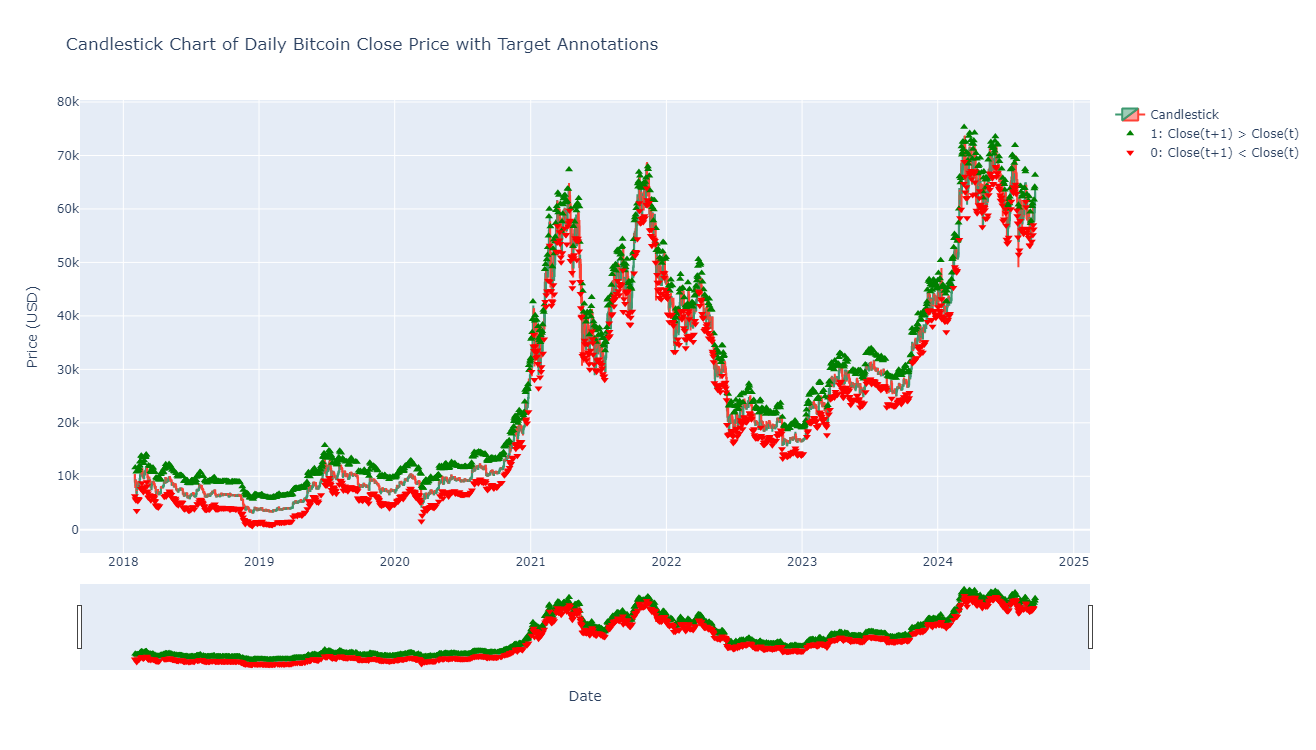

In [19]:
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     name='Candlestick')])

fig.add_trace(go.Scatter(x=df[df['target'] == 1]['date'],
                         y=df[df['target'] == 1]['high'] + 2500,
                         mode='markers',
                         marker=dict(color='green', symbol='triangle-up', size=7),
                         name='1: Close(t+1) > Close(t)',
                         hoverinfo='skip'))

fig.add_trace(go.Scatter(x=df[df['target'] == 0]['date'],
                         y=df[df['target'] == 0]['low'] - 2500,
                         mode='markers',
                         marker=dict(color='red', symbol='triangle-down', size=7),
                         name='0: Close(t+1) < Close(t)',
                         hoverinfo='skip'))

fig.update_layout(height=750,
                  title='Candlestick Chart of Daily Bitcoin Close Price with Target Annotations',
                  yaxis_title='Price (USD)',
                  xaxis_title='Date')
fig.show()

#### Seasonal Decomposition

In [21]:
df2 = df.copy()
df2.set_index('date',inplace=True)
daily_data = df2['close'].resample('D').sum()
daily_data.head()

date
2018-02-01    9170.540039
2018-02-02    8830.750000
2018-02-03    9174.910156
2018-02-04    8277.009766
2018-02-05    6955.270020
Freq: D, Name: close, dtype: float64

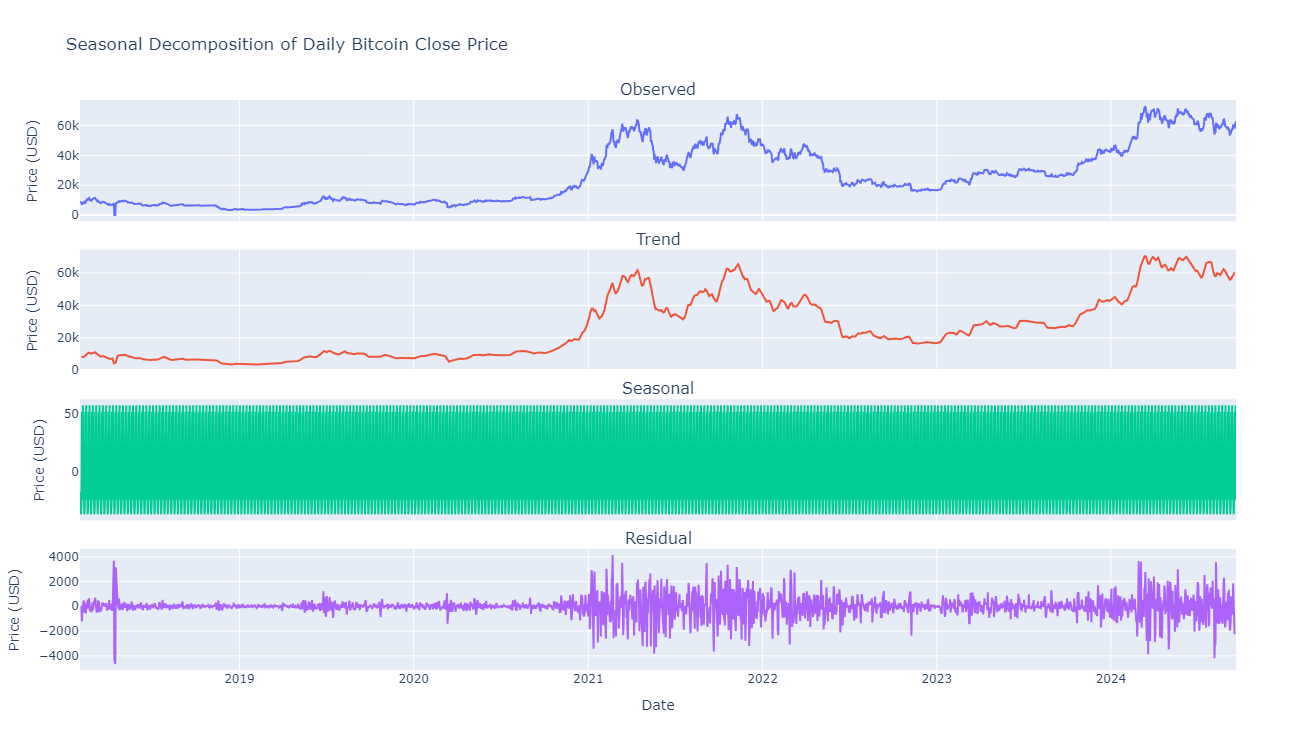

In [22]:
result = seasonal_decompose(daily_data)

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

fig.add_trace(go.Scatter(x=daily_data.index, y=result.observed, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_data.index, y=result.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=daily_data.index, y=result.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=daily_data.index, y=result.resid, mode='lines', name='Residual'), row=4, col=1)

fig.update_yaxes(title_text='Price (USD)')
fig.update_xaxes(title_text='Date', row=4)
fig.update_layout(height=750, title_text='Seasonal Decomposition of Daily Bitcoin Close Price', showlegend=False)
fig.show()

Interpreting seasonal decomposition:
- Observed: The original time series data.
- Trend: General direction of the data over time, ignoring short-term fluctuations. Captures long-term patterns.
- Seasonal: Repeating short-term cycle in the data, reflecting variations at regular intervals.
- Residual: The remainder after factoring trend and seasonal components. "Noise" or random variation.

Interpretation:
- Trend: Like "Observed" but smoother with "Seasonal" and "Residual" components factored out.
- Seasonal: Weekly cycle. Range of -38 to 56. Highest on Mondays, lowest on Saturdays.
- Residual: Range of -4.6k to 4.1k. "Residual":"Seasonal" ratio can be as high as 100:1 or as low as 1:1. High noise suggests that the currency is volatile and can be hard to predict.

#### Correlation Plot / Heatmap

In [25]:
non_binary_df = pd.concat([
    df[['fng_value']],
    df.iloc[:,3:21],
    df.iloc[:,25:31],
], axis=1)
non_binary_df.columns

Index(['fng_value', 'open', 'high', 'low', 'close', 'volume', 'close_t+1',
       'close_change', 'close_t+1_change', 'sma_3d', 'sma_7d', 'sma_14d',
       'ema_5d', 'ema_10d', 'ema_21d', 'std_14d', 'upper_band', 'lower_band',
       'rsi', 'target', 'fng_change', 'year', 'month', 'day', 'day_of_week'],
      dtype='object')

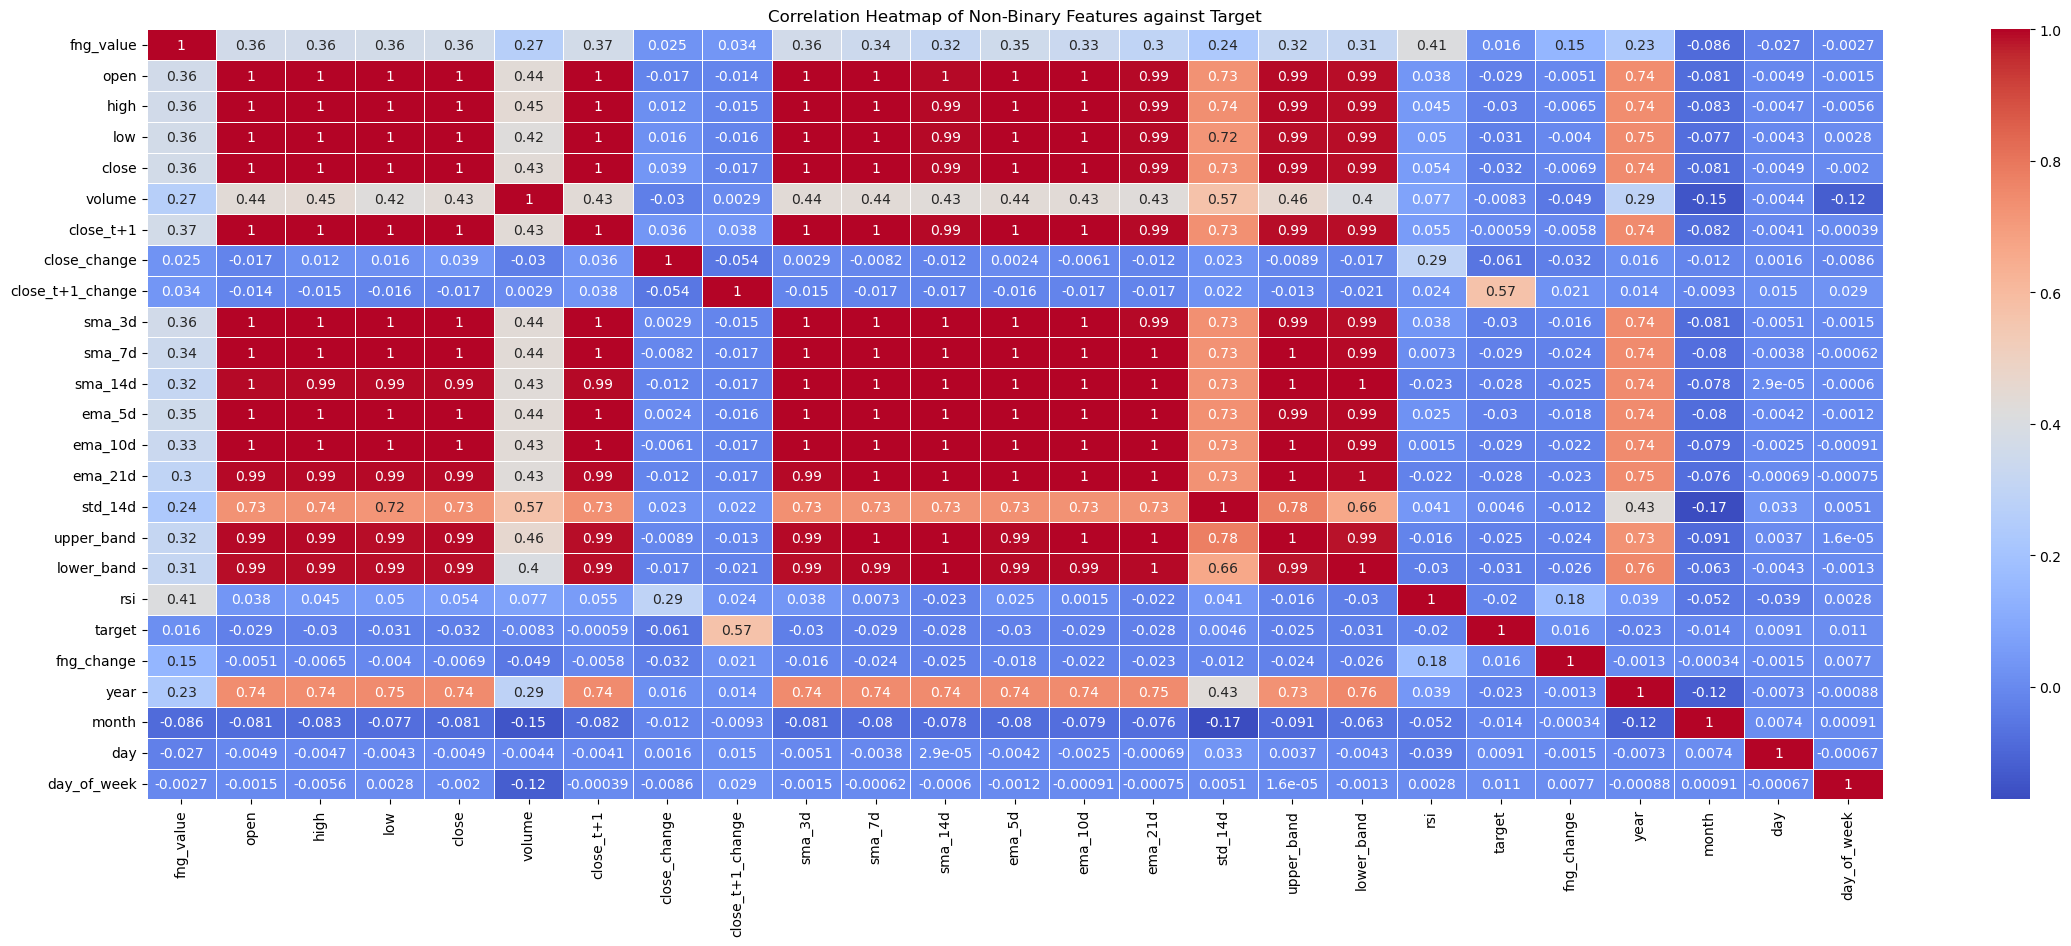

In [26]:
plt.figure(figsize=(28,10))
sns.heatmap(non_binary_df.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Heatmap of Non-Binary Features against Target')
plt.show()

- Target has moderate correlation with close_t+1_change (unbinarized target) but the latter cannot be used as a feature as it is future data, which would cause data leakage during model training.
- No other variables correlate well with target or close_t+1_change (the best being close_change at -0.061 and -0.054 respectively); this could be due to the presence of high noise in the data, which is supported by observations from the earlier seasonal decomposition.

In [28]:
binary_df = pd.concat([
    df.iloc[:,21:26],
], axis=1)
binary_df.columns

Index(['close_dir', 'high_dir', 'low_dir', 'volume_dir', 'target'], dtype='object')

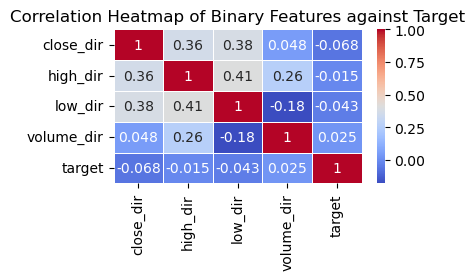

In [29]:
plt.figure(figsize=(4,2))
sns.heatmap(binary_df.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Heatmap of Binary Features against Target')
plt.show()

- No variables correlate well with target (the best being close_dir at -0.068).

#### Bar Plot

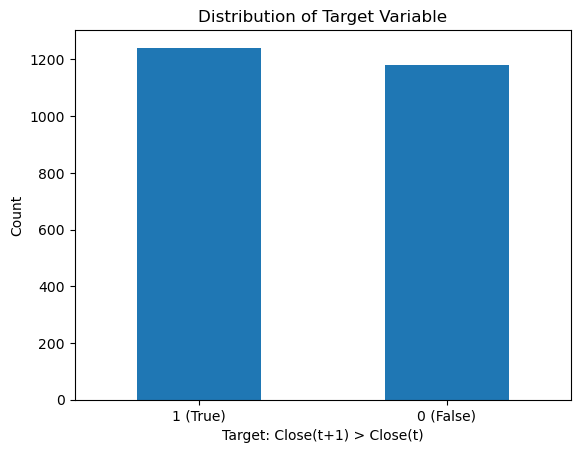

In [32]:
df['target'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Target: Close(t+1) > Close(t)')
plt.title('Distribution of Target Variable')
plt.xticks([0,1], ['1 (True)','0 (False)'],rotation=0)
plt.show()

- Target is reasonably distributed. Accuracy can be used over ROC-AUC in subsequent model training.

### 3. Statistical Analysis

Based on the above observations — in particular, high noise in the data at certain intervals — we should check if close prices between consecutive days significantly differ from one another.

In [36]:
alpha = 0.05

t_stat, p_value = stats.ttest_rel(df['close'], df['close_t+1'])
print(f"Paired t-test of Close(t) vs Close(t+1): t-statistic = {t_stat}, p-value = {p_value}")
print()

if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than the significance level ({alpha}).")
    print('The null hypothesis is rejected.')
    print('There is a statistically significant difference between Close(t) and Close(t+1).')
else:
    print(f"The p-value ({p_value:.4f}) is greater than or equal to the significance level ({alpha}).")
    print('Failed to reject the null hypothesis.')
    print('There is no statistically significant difference between Close(t) and Close(t+1).')

Paired t-test of Close(t) vs Close(t+1): t-statistic = -1.0203061366207862, p-value = 0.3076853224449316

The p-value (0.3077) is greater than or equal to the significance level (0.05).
Failed to reject the null hypothesis.
There is no statistically significant difference between Close(t) and Close(t+1).


Interpretation:
- Close prices between consecutive days are not significantly different, suggesting that Bitcoin's day-to-day price changes are subject to random fluctuations with no systematic increase or decrease despite long-term trend changes.
- Random fluctuations could be explained by market efficiency i.e. prices reflecting all available information at the time (e.g. news, announcements).
- However, this also suggests that the daily time interval may not be optimal for detecting price changes.

### 4. Machine Learning Model Development

#### Train-Test Split

In [40]:
df.columns

Index(['date', 'fng_value', 'fng_class', 'open', 'high', 'low', 'close',
       'volume', 'close_t+1', 'close_change', 'close_t+1_change', 'sma_3d',
       'sma_7d', 'sma_14d', 'ema_5d', 'ema_10d', 'ema_21d', 'std_14d',
       'upper_band', 'lower_band', 'rsi', 'close_dir', 'high_dir', 'low_dir',
       'volume_dir', 'target', 'fng_change', 'year', 'month', 'day',
       'day_of_week'],
      dtype='object')

In [41]:
X = df[['fng_value','rsi','fng_change','month','day','day_of_week',
        'fng_class','year',
        'close_dir','high_dir','low_dir','volume_dir', # passthrough
       ]]
y = df['target']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1936, 12), (484, 12), (1936,), (484,))

#### Feature Scaling

In [44]:
# df.columns

In [45]:
# df['close'].hist()
# plt.yscale('log')
# plt.xscale('log')

In [182]:
def scale_stats(columns):
    for col in columns: 
        skew = round(df[col].skew(),3)
        min = round(df[col].min(),3)
        median = round(df[col].median(),3)
        max = round(df[col].max(),3)
        print(col, skew)
        print(min, median, max)
        print()

# scale_stats(['fng_value'])
# scale_stats(df.columns[3:])
df[df['fng_value'] == 26]

date  fng_value fng_class          open          high  \
72   2018-04-17         26      Fear   8071.660156   8285.959961   
75   2018-04-20         26      Fear   8286.879883   8880.230469   
108  2018-05-23         26      Fear   8037.080078   8054.660156   
121  2018-06-05         26      Fear   7500.899902   7643.229980   
131  2018-06-15         26      Fear   6674.080078   6681.080078   
197  2018-08-20         26      Fear   6500.509766   6536.919922   
212  2018-09-04         26      Fear   7263.000000   7388.259766   
246  2018-10-08         26      Fear   6600.189941   6675.060059   
256  2018-10-18         26      Fear   6542.330078   6567.540039   
287  2018-11-18         26      Fear   5559.740234   5653.609863   
325  2018-12-26         26      Fear   3819.666748   3893.359619   
330  2018-12-31         26      Fear   3866.839111   3868.742920   
674  2019-12-10         26      Fear   7397.134277   7424.022949   
814  2020-04-28         26      Fear   7796.970215   7814.527344   
815  2020-04-29         26      Fear   7806.712402   8871.753906   
1195 2021-05-14         26      Fear  49682.980469  51438.117188   
1229 2021-06-17         26      Fear  38341.421875  39513.671875   
1268 2021-07-26         26      Fear  35384.031250  40499.675781   
1331 2021-09-27         26      Fear  43234.183594  44313.246094   
1458 2022-02-01         26      Fear  38481.765625  39115.132812   
1483 2022-02-26         26      Fear  39213.082031  40005.347656   
1484 2022-02-27         26      Fear  39098.699219  39778.941406   
1507 2022-03-22         26      Fear  41074.105469  43124.707031   
1538 2022-04-22         26      Fear  40525.863281  40777.757812   
1633 2022-07-26         26      Fear  21361.121094  21361.121094   
1680 2022-09-11         26      Fear  21678.542969  21770.552734   
1705 2022-10-06         26      Fear  20161.039062  20408.392578   
1757 2022-11-27         26      Fear  16463.882812  16594.406250   
1759 2022-11-29         26      Fear  16217.639648  16522.257812   
1764 2022-12-04         26      Fear  16908.169922  17157.767578   
1765 2022-12-05         26      Fear  17128.894531  17378.152344   
1769 2022-12-09         26      Fear  17232.148438  17280.546875   
1771 2022-12-11         26      Fear  17129.710938  17245.634766   
1778 2022-12-18         26      Fear  16795.609375  16815.386719   
1781 2022-12-21         26      Fear  16904.527344  16916.800781   
1792 2023-01-01         26      Fear  16547.914062  16630.439453   
1794 2023-01-03         26      Fear  16688.847656  16760.447266   
1797 2023-01-06         26      Fear  16836.472656  16991.994141   
1801 2023-01-10         26      Fear  17192.949219  17484.720703   
1802 2023-01-11         26      Fear  17446.359375  17934.896484   
2344 2024-07-06         26      Fear  56659.074219  58472.546875   
2374 2024-08-05         26      Fear  58110.296875  58268.828125   
2390 2024-08-21         26      Fear  59014.988281  61834.351562   
2401 2024-09-01         26      Fear  58969.800781  59062.070312   
2402 2024-09-02         26      Fear  57326.968750  59403.070312   
2403 2024-09-03         26      Fear  59106.191406  59815.058594   
2409 2024-09-09         26      Fear  54851.886719  58041.125000   

               low         close        volume     close_t+1  close_change  \
72     7881.720215   7902.089844    6900879872   8163.419922   -156.580078   
75     8244.540039   8845.830078    8438110208   8895.580078    551.520508   
108    7507.879883   7557.819824    6491120128   7587.339844   -483.959961   
121    7397.000000   7633.759766    4961739776   7653.979980    119.289551   
131    6433.870117   6456.580078    3955389952   6550.160156   -218.770020   
197    6297.930176   6308.529785    3665100000   6488.759766   -197.540039   
212    7255.439941   7361.660156    4273640000   6792.830078    101.600098   
246    6576.040039   6652.229980    3979460000   6642.640137     49.279785   
256    6450.040039   6476.709961    39240800

In [47]:
# prior engineered features retained but commented out for future reference
log_standard_cols = [
    # # skew > 0.99
    # 'volume_btc_usd', 'volume_btc_eur', 'volume_eth_usd', # max 3.3
    # 'rr_volume_btc_usd', 'rr_volume_btc_eur', 'rr_volume_eth_usd', # max 3.7
    # 'rel_volume_btc_usd', 'rel_volume_btc_eur', 'rel_volume_eth_usd',
    
    # 'std_14d_btc_usd', 'std_14d_btc_eur', 'std_14d_eth_usd',
    
    # 'open_t+1:close_btc_usd', 'open_t+1:close_btc_eur', 'open_t+1:close_eth_usd', # max 20
]

standard_cols = [
    # # normally distributed
    # 'close:open_btc_usd', 'close:open_btc_eur', 'close:open_eth_usd',
    # 'usd:eur_open_t+1',
    
    # # 0.99 > skew > 0.5
    # 'open_btc_usd', 'open_btc_eur', 'open_eth_usd',
    # 'high_btc_usd', 'high_btc_eur', 'high_eth_usd',
    # 'low_btc_usd', 'low_btc_eur', 'low_eth_usd',
    # 'close_btc_usd', 'close_btc_eur', 'close_eth_usd',

    # 'open_t+1_btc_usd', 'open_t+1_btc_eur', 'open_t+1_eth_usd',
    
    # # skew < 0.5
    # 'sma_3d_btc_usd', 'sma_3d_btc_eur', 'sma_3d_eth_usd',
    # 'sma_7d_btc_usd', 'sma_7d_btc_eur', 'sma_7d_eth_usd',
    # 'sma_14d_btc_usd', 'sma_14d_btc_eur', 'sma_14d_eth_usd',
    # 'ema_5d_btc_usd', 'ema_5d_btc_eur', 'ema_5d_eth_usd',
    # 'ema_10d_btc_usd', 'ema_10d_btc_eur', 'ema_10d_eth_usd',
    # 'ema_21d_btc_usd', 'ema_21d_btc_eur', 'ema_21d_eth_usd',
    # 'upper_band_btc_usd', 'upper_band_btc_eur', 'upper_band_eth_usd',
    # 'lower_band_btc_usd', 'lower_band_btc_eur', 'lower_band_eth_usd',
]

minmax_cols = [
    'fng_value', # 0-100
    'rsi', # 'rsi_eth_usd', 'rsi_btc_eur', # 0-100
    'fng_change', # -50-50
    'month', # 1-12
    'day', # 1-31
    'day_of_week', # 0-6
]

# cyclical_cols = ['month', 'day', 'day_of_week']

cat_cols = [
    'fng_class',
    # 'sma_3d_dir','sma_7d_dir','sma_14d_dir','ema_5d_dir','ema_10d_dir','ema_21d_dir', 
    'year',
]

passthrough = [
    'close_dir', 'high_dir', 'low_dir', 'volume_dir',
    # 'rr_high_btc_usd', 'rr_high_btc_eur', 'rr_high_eth_usd',
    # 'rr_low_btc_usd', 'rr_low_btc_eur', 'rr_low_eth_usd',
    # 'rr_close_btc_usd', 'rr_close_btc_eur', 'rr_close_eth_usd',
]

In [48]:
# log_standard_pipeline = make_pipeline(
#     FunctionTransformer(np.log1p, validate=True),
#     StandardScaler()
# )
# def cyclical_encode(x):
#     sin_x = np.sin(2 * np.pi * x / np.max(x))
#     cos_x = np.cos(2 * np.pi * x / np.max(x))
#     return np.hstack([sin_x, cos_x])
# cyclical_transformer = FunctionTransformer(cyclical_encode, validate=True)

preprocessor = make_column_transformer(
    # (log_standard_pipeline, log_standard_cols),
    # (StandardScaler(), standard_cols),
    (MinMaxScaler(), minmax_cols),
    (OneHotEncoder(), cat_cols ), # 5+7-2=10
    remainder='passthrough'
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_train)
X_train_p.shape, X_test_p.shape

((1936, 22), (1936, 22))

#### Model Training & Validation

In [50]:
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    XGBClassifier(),
    LGBMClassifier(random_state=42)
]

In [51]:
for model in models:
    # accuracy used as target distributed
    cv_score = cross_val_score(model, X_train_p, y_train, cv=5, scoring='accuracy') 
    print(f"{model} - Mean Accuracy: {cv_score.mean():.3f} (±{cv_score.std()*2:.3f})")

LogisticRegression(random_state=42) - Mean Accuracy: 0.525 (±0.059)
DecisionTreeClassifier(random_state=42) - Mean Accuracy: 0.496 (±0.023)
RandomForestClassifier(random_state=42) - Mean Accuracy: 0.488 (±0.019)
GradientBoostingClassifier(random_state=42) - Mean Accuracy: 0.508 (±0.064)
BaggingClassifier(random_state=42) - Mean Accuracy: 0.496 (±0.038)
AdaBoostClassifier(random_state=42) - Mean Accuracy: 0.507 (±0.034)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_w

### 5. Model Evaluation & Interpretation

#### Pipeline, Export

In [54]:
# LGBMClassifier selected for highest mean accuracy
best_model = LGBMClassifier(random_state=42)
pipeline = make_pipeline(preprocessor, best_model)
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 998, number of negative: 938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 1936, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515496 -> initscore=0.062003
[LightGBM] [Info] Start training from score 0.062003


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['fng_value', 'rsi',
                                                   'fng_change', 'month', 'day',
                                                   'day_of_week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['fng_class', 'year'])])),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [101]:
with open('streamlit/assets/LGBM_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

#### Metrics

In [57]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [58]:
print('Model performance on test set:')
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

Model performance on test set:
Accuracy: 0.519
Precision: 0.520
Recall: 0.539
F1-score: 0.529
ROC AUC: 0.512


#### Feature Importances

In [60]:
feature_names = preprocessor.get_feature_names_out()
best_model.fit(X_train_p, y_train)
feature_importances = best_model.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)

[LightGBM] [Info] Number of positive: 998, number of negative: 938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 1936, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515496 -> initscore=0.062003
[LightGBM] [Info] Start training from score 0.062003


In [61]:
print('Top 10 features:')
for feature, importance in sorted_feature_importances[:10]:
    print(f"{feature}: {importance}")

Top 10 features:
minmaxscaler__rsi: 791
minmaxscaler__fng_value: 524
minmaxscaler__day: 421
minmaxscaler__fng_change: 360
minmaxscaler__month: 277
minmaxscaler__day_of_week: 217
remainder__volume_dir: 62
remainder__close_dir: 57
remainder__low_dir: 52
remainder__high_dir: 47


Interpretation:
- LGBM's .feature_importances_ returns the number of times a feature is used to split a node across all trees in the ensemble.
- RSI is used 791 times and contributes most often to the decision-making process.

### 6. Insight & Recommendations

Bitcoin is a volatile cryptocurrency, thus a need for robust time series forecasting models that are able to make accurate future predictions which can facilitate investment decisions despite the currency's fluctuations. Some of the classification models above were able to make correct predictions above chance (>0.5), but much remains to be desired.

One limitation is the quality of features used. Features selected for model training did not correlate well with target or close_t+1_change (the latter being the "target" for regression models). The magnitude of Bitcoin's price and volume — as well as random spikes in them — also obscure correlations, complicating feature scaling and selection. Given more time, additional features that 1) have lower skew; and 2) correlate better with target or close_t+1_change can be engineered to improve model prediction.

Considering Fear & Greed Index's low correlation to target or close_t+1_change, the factors comprising it (e.g. volatility, social media, trends) may be inadequate for or irrelevant to price prediction. A low correlation could also be due to the index's factors contributing effects of opposite directions that cancel each other out.

As observed in the earlier seasonal decomposition, Bitcoin has lulls and volatile periods. With more time, the data could be separated into intervals based on the currency's volatility for any given period. A stationarity check could then be performed to ensure properties of the data (e.g. mean, variance) do not change over time for said period; intervals that pass the check can then be used to train a model with improved accuracy (e.g. ARIMA, which has a stationary data prerequisite). However, such a model may still prove inaccurate in volatile market conditions.

As per the paired t-test, a dedicated feature (instead of a composite index like Fear & Greed) that reflects market sentiment could be engineered to improve model prediction. However, such a feature may be time-consuming to create or arbitrarily defined. Alternatively, price fluctuations of a time interval other than day (e.g. minute, month) can be investigated to see if they can more reliably predict price (direction).

Other volatility factors include changes in market behavior due to the COVID-19 lockdown, as well as crypto whale activity.